In [ ]:
# imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms, models
import os
import pandas as pd
from skimage import io

In [ ]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
# set hyperparameters
batch_size = 128
learning_rate = 0.00001

In [ ]:
# read in the dataset

# mount the google drive data
from google.colab import drive
drive.mount('/content/drive')

# define a custom dataset class
class PetFinderDataset(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index,0]+".jpg")
    image = io.imread(img_path)
    # y_label = torch.tensor((int(self.annotations.iloc[index, 13]))/100) # regression
    y_label = torch.tensor((int(self.annotations.iloc[index, 13]))//10)
    
    if self.transform:
      image = self.transform(image)
    
    return (image, y_label)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from torch.utils import data
# data preprocessing: reshape and normalize (meet the requirement of resnet18)
preprocess_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])


# load the data, divide into train and validation dataset and transform
dataset = PetFinderDataset(csv_file = "/content/drive/MyDrive/petfinder-pawpularity-score/train2.csv", 
                           root_dir = "/content/drive/MyDrive/petfinder-pawpularity-score/train",
                           transform = preprocess_train)
# print(len(dataset))
train_set, val_set = torch.utils.data.random_split(dataset,[400, 98]) # 
# train_set, val_set = torch.utils.data.random_split(dataset,[9656,256]) # test
train_loader = DataLoader(dataset = train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset = val_set, batch_size=batch_size, shuffle=True)

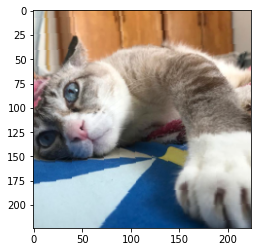

In [ ]:
import matplotlib.pyplot as plt
image = io.imread("/content/drive/MyDrive/petfinder-pawpularity-score/train/ff602c36a58c20d88fd0f543fd671040.jpg")
check_preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomAffine(10),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    ])
image = check_preprocess(image)
image = transforms.ToPILImage()(image).convert("RGB")
plt.imshow(image)
plt.show()

In [ ]:
def check_test_loss(test_loader, model):
  loss = 0.0
  number_samples = 0
  criterion = nn.MSELoss(reduction="sum")
  model.eval()
  with torch.no_grad():
    for x, y in test_loader:
      x = x.to(device)
      y = y.to(device)
      y = y.unsqueeze(1)
      score = model(x)
      # print(score)
      # print(y)
      loss += criterion(score, y).sum()
      number_samples += y.size(0)
    RMSE = torch.sqrt(loss/number_samples)
    print(f"test number of samples: %d "%number_samples)
    print(f"test RMSE: %.3f" % RMSE)
  return RMSE

In [ ]:
# model.to(device)
# check_test_loss(val_loader, model)

In [ ]:
# define a train function
def train(net, train_iter, test_iter, num_epochs, lr, device, train_loss, test_loss):
    # def init_weights(m):
    #     if type(m) == nn.Linear or type(m) == nn.Conv2d:
    #         nn.init.xavier_uniform_(m.weight)
    # net.apply(init_weights) 
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=lr, momentum = 0.9, weight_decay= 0)
    # loss = nn.MSELoss(reduction="sum")
    loss = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0;
        number_samples = 0
        for i, (X, y) in enumerate(train_iter):
            number_samples += y.size(0)
            # if (i%10==0): print("batch: "+str(i))
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            # print(X.shape)
            y_hat = net(X)
            print(y)
            print(y_hat)
            y = y.to(torch.float32)
            y = y.unsqueeze(1)
            y_hat = y_hat.to(torch.float32)
            l = loss(y_hat, y)
            # print("y_hat shape:" + y_hat.shape)
            # print("y shape:" + y.shape)
            l.backward()
            optimizer.step()
            running_loss += l.sum()
            # if (i%10==0): 
            #   print("y_hat:")
            #   print(y_hat)
            #   print("y:")
            #   print(y)
            # if (epoch%5==0 and i==60): print(y_hat)
        print('[%d] train loss: %.3f' % (epoch+1,running_loss))
        print('[%d] number of samples: %d' % (epoch+1,number_samples))
        print('[%d] train average loss: %.3f' % (epoch+1,running_loss/number_samples))
        print('[%d] train RMSE: %.3f' % (epoch+1,torch.sqrt(running_loss/number_samples)))
        train_loss.append(torch.sqrt(running_loss/number_samples))
        test_loss.append(check_test_loss(test_iter, net))
    print("finish running")


In [ ]:
# Initialize a baseline CNN model resnet 18
model = models.resnet50(pretrained=True)
#model.fc = nn.Sequential(nn.Linear(2048, 10), nn.ReLU(inplace=True),nn.Linear(10, 1) ) # regression
model.fc = nn.Sequential(nn.Linear(2048, 10))

# for name, param in model.named_parameters():
#   if param.requires_grad:
#     if (name.find("fc") == -1 and name.find("layer4") == -1):
#       param.requires_grad = False

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

# model = models.resnet50()
# model.fc = nn.Sequential(nn.Linear(2048, 10), nn.ReLU(), nn.Linear(10, 1)) # modify resnet18 because this is a regression problem
# model.load_state_dict(torch.load("/content/resnet50.pth"))
model.fc.apply(init_weights)
# model.eval()

NameError: ignored

In [ ]:
for name, param in model.named_parameters():
  if param.requires_grad:print(name)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

In [ ]:
train_loss = []
test_loss = []

In [ ]:
train_loss

[]

In [ ]:
test_loss

[]

In [ ]:
train(model, train_loader, val_loader, 5, 0.000005, device, train_loss, test_loss)

training on cpu


In [ ]:
# download the model
torch.save(model.state_dict(), "resnet50.pth")

from google.colab import files
files.download('resnet50.pth')

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt

def display(loader, model):
  model.eval()
  with torch.no_grad():
    for x, y in loader:
      # x = x.to(device)
      # y = y.to(device)
      # y = y.unsqueeze(1)
      # score = model(x)
      # print(score)
      for image in x:
        image = image.view(image.shape[1], image.shape[2], image.shape[0])
        plt.imshow(image)
      # print(score)
      # print(y)


In [ ]:
display(val_loader, model)